In [36]:
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [37]:
k,gamma,D = 1.0,1.0,1.0
delta_t=0.01
ampl = np.sqrt(2*D*delta_t)
N=1000

In [38]:
# random force
w=np.random.normal(0,1,N)

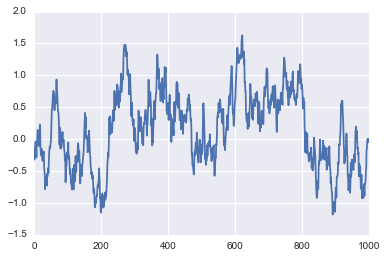

In [39]:
# differential equation x_i = x_(i-1) - k/gamma*x_(i-1) + sqrt(2*D*delta_t)*w_i
from itertools import accumulate
def next_point(x,y):
    return x - k/gamma*x*delta_t + ampl*y

x = np.fromiter(accumulate(w, next_point),np.float)
plt.plot(x)

In [40]:
print("std: ",x.std(),"mean: ",x.mean())

std:  0.583469747063 mean:  0.155874018735


In [41]:
# see http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.fftconvolve.html
from scipy import signal
autocorr = signal.fftconvolve(x, x[::-1], mode='full')

1999


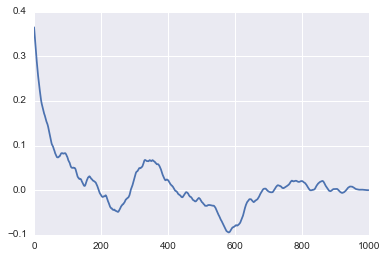

In [42]:
n=len(autocorr)
print(n)
autocorr=autocorr[int((n-1)/2):]*2.0/(n+1)
plt.plot(autocorr[:1000])

In [43]:
import lmfit as lm

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.450
    reduced chi-square = 0.001
    Akaike info crit   = -3500.068
    Bayesian info crit = -3491.638
[[Variables]]
    decay:       51.5894335 +/- 1.841871 (3.57%) (init= 231.9927)
    amplitude:   0.32854999 +/- 0.008214 (2.50%) (init= 0.0941475)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.700 



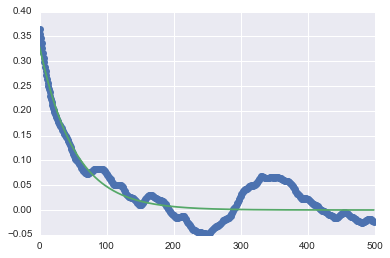

In [44]:
from lmfit.models import ExponentialModel

mod = ExponentialModel()
y = autocorr[:500]
t = np.arange(500)

pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.plot(t,y,"o")
plt.plot(t,out.best_fit)

In [45]:
# now lets model this data using pymc
import pymc as pm

In [46]:
# define the model/function to be fitted.
def model(x): 
    t = pm.Uniform('t', 0.1, 4, value= 1.0)
    A = pm.Uniform('A', 0.1, 2, value= 1.0)
    
    @pm.deterministic(plot=False)
    def S(t=t):
        return 1-np.exp(-4*delta_t/t)
    
    @pm.deterministic(plot=False)
    def s(t=t):
        return np.exp(-2*delta_t/t)
        
    path = np.empty(N, dtype=object)
    
    path[0]=pm.Normal('path_0',mu=0, tau=1/A, value=x[0], observed=True)
    for i in range(1,N):
        path[i] = pm.Normal('path_%i' % i,
                            mu=path[i-1]*s,
                            tau=1/A/S,
                            value=x[i],
                            observed=True)
    return locals()

MDL = pm.MCMC(model(x))
MDL.sample(20000, 10000, 1)

 [-----------------100%-----------------] 20000 of 20000 complete in 1042.3 sec

Plotting t
Plotting A


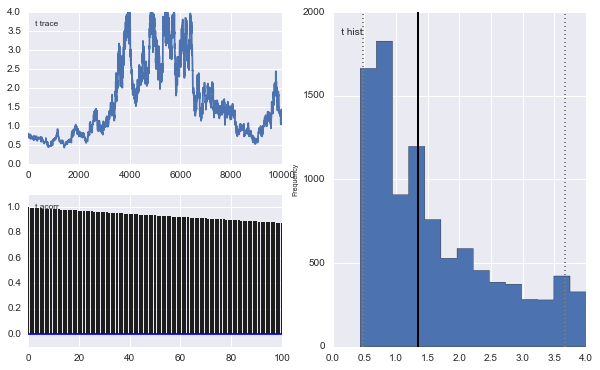

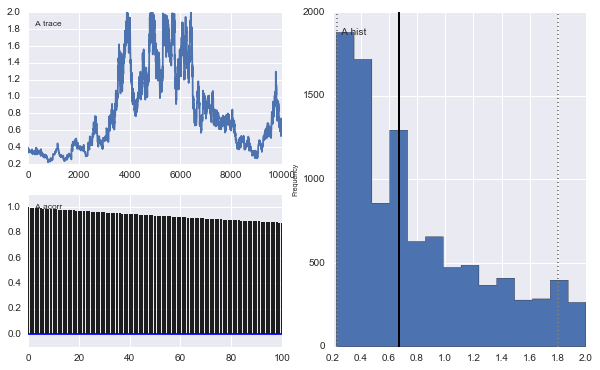

In [47]:
pm.Matplot.plot(MDL)

In [48]:
MDL.summary()


s:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.983            0.01             0.001            [ 0.966  0.995]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.962            0.975           0.985          0.991         0.995
	

t:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.617            0.977            0.096            [ 0.474  3.662]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.518            0.801           1.345          2.237         3.799
	

A:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------------------